In [9]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from numpy.random import normal
import math
import usefulFunctions
from random import randrange

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
control = {}
sick = {}
male = {}
female = {}
age = []
months = []

fileName = "Master_PL.xlsx - Master_PL.csv"
table = pd.read_csv(fileName, header=0, 
                    names=["id", "type", "gender", "age", "monthsFromScreening", "protein_BL", "protein_V4",
                          "protein_V6", "protein_V8", "protein_V10", "protein_V12"])

totalRows = len(table.values)

# splitting data into female vs male, control vs sick, plus storing the age and months data
# into arrays so we can look at their distributions later (to understand good age bands)
for row in table.to_dict(orient='records'):
    if row['type'] is not None:
        if row['type'] == 1:
            control[int(row['id'])] = row
        else:
            sick[int(row['id'])] = row
    
    if row['gender'] is not None:
        if row['gender'] == 1:
            female[int(row['id'])] = row
        else:
            male[int(row['id'])] = row

    
    if row['age'] is not None:
        age.append(row['age'])
    
    if row['monthsFromScreening'] is not None:
        months.append(row['monthsFromScreening'])

print "Number of data points that are males : " + str(len(male))
print "Number of data points that are females : " + str(len(female))
print "Number of data points that are control : " + str(len(control))
print "Number of data points that are sick : " + str(len(sick))

Number of data points that are males : 403
Number of data points that are females : 216
Number of data points that are control : 196
Number of data points that are sick : 423


In [11]:
tup = usefulFunctions.combine(male, female, control, sick)
maleSplit = tup[0]
femaleSplit = tup[1]
print "Number of Males that are in the Control : " + str(len(maleSplit[0]))
print "Number of Males that are Sick : " + str(len(maleSplit[1]))
print "Number of Females that are in the Control : " + str(len(femaleSplit[0]))
print "Number of Females that are Sick : " + str(len(femaleSplit[1]))

Number of Males that are in the Control : 126
Number of Males that are Sick : 277
Number of Females that are in the Control : 70
Number of Females that are Sick : 146


In [23]:
# getting only fully filled out entries to plot
proteinKeys = ['protein_BL', 'protein_V4', 'protein_V6', 'protein_V8', 'protein_V10', 'protein_V12']

def getFullValuesOnly(dic, filterOutliers=True):
    fullEntities = []
    for key in dic:
        entity = dic[key]
        valid = True
        for key2 in proteinKeys:
            if not usefulFunctions.checkForValid(entity[key2]):
                valid = False
            if filterOutliers:
                if entity[key2] >= 100 or entity[key2] <= 10:
                    valid = False
        if valid:
            temp = []
            for key2 in proteinKeys:
                temp.append(entity[key2])
        
            fullEntities.append(temp)
        
    return fullEntities

controlMales = getFullValuesOnly(maleSplit[0])
sickMales = getFullValuesOnly(maleSplit[1])
controlFemales = getFullValuesOnly(femaleSplit[0])
sickFemales = getFullValuesOnly(femaleSplit[1])

In [24]:
len(controlMales), len(controlFemales)

(18, 13)

In [25]:
len(sickMales), len(sickFemales)

(33, 11)

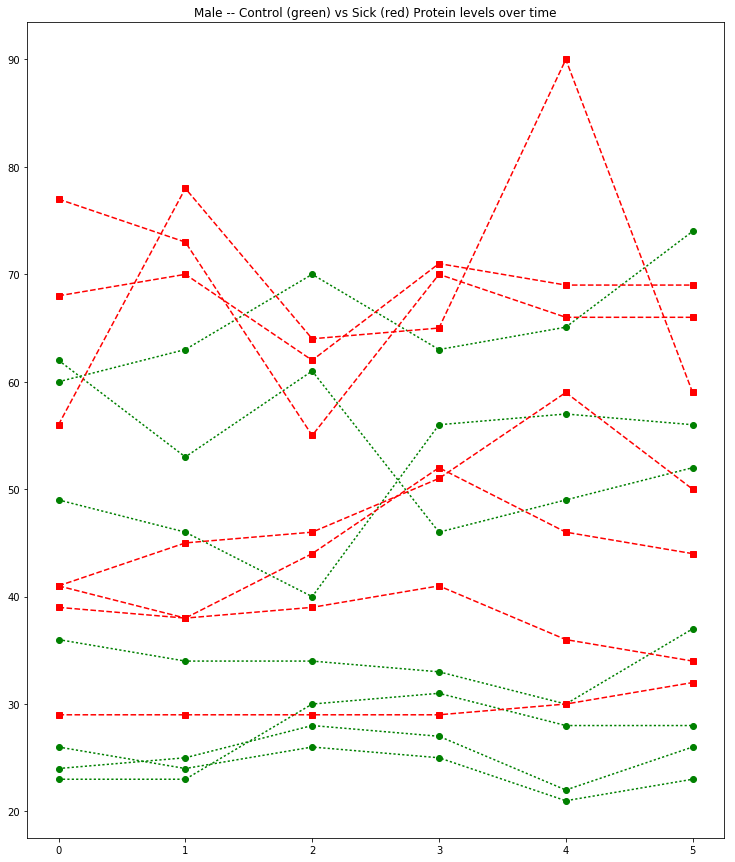

In [63]:
def selectRandom(arr, n):
    random = []
    size = len(arr)
    for i in range(n):
        index = randrange(0, size)
        random.append(arr[index])
        temp = arr[index]
        arr[index] =  arr[size-1]
        arr[size-1] = temp
        size +=-1
    return random

randomControlMales = selectRandom(controlMales, 7)
randomSickMales = selectRandom(sickMales, 7)

labels = []
for entry in randomControlMales:
    labels.append(0)
for entry in randomSickMales:
    labels.append(1)

allFullyFilledMales = randomControlMales + randomSickMales
colors = ['go:', 'rs--']
title = "Male -- Control (green) vs Sick (red) Protein levels over time"
usefulFunctions.createLinePlotsOnSamePlot(allFullyFilledMales, labels, colors, title)
# green is control
# red is sick

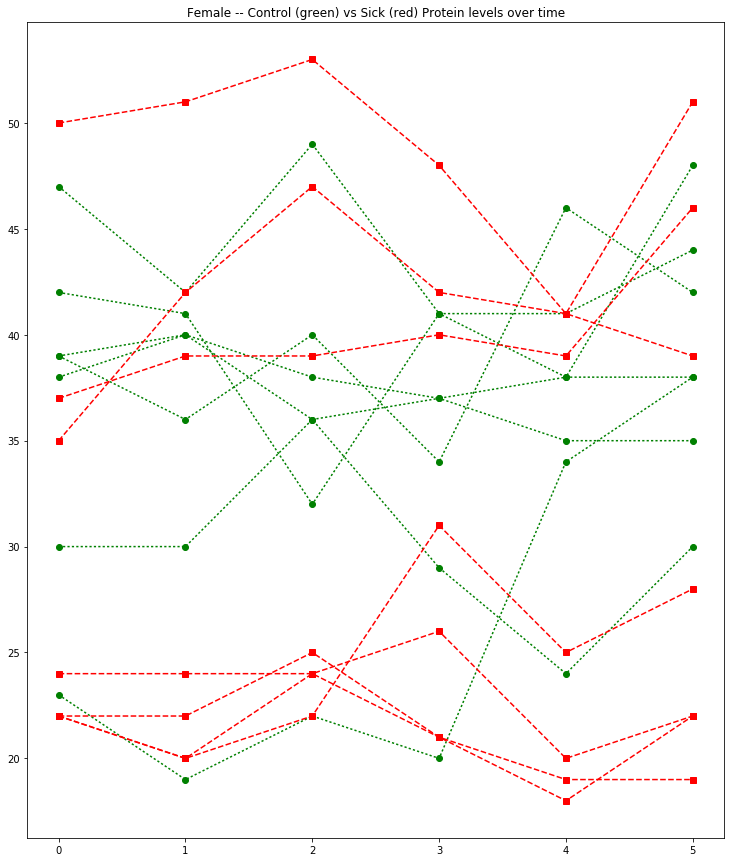

In [70]:
randomControlFemales = []
randomSickFemales = []

randomControlFemales = selectRandom(controlFemales, 7)
randomSickFemales = selectRandom(sickFemales, 7)

labels = []
for entry in randomControlFemales:
    labels.append(0)
for entry in randomSickFemales:
    labels.append(1)

allFullyFilledFemales = randomControlFemales + randomSickFemales
colors = ['go:', 'rs--']
title = "Female -- Control (green) vs Sick (red) Protein levels over time"

usefulFunctions.createLinePlotsOnSamePlot(allFullyFilledFemales, labels, colors, title)

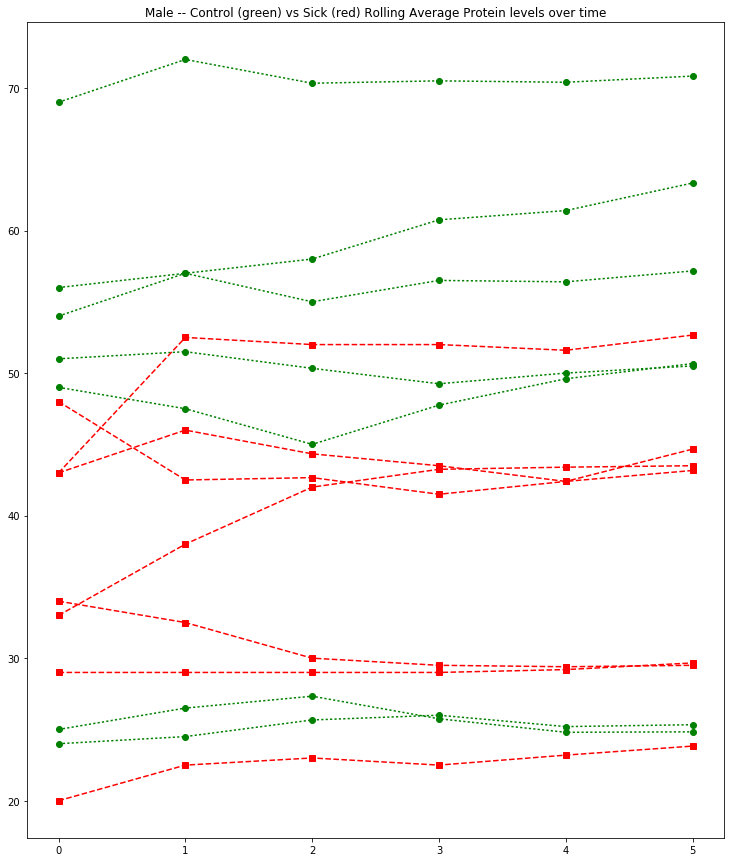

In [65]:
def computeRollingAverages(matrix):
    rollingAverageMatrix = []
    for i in range(len(matrix)):
        row = matrix[i]
        temp = []
        temp.append((row[0], row[0]))
        for j in range(1,len(row)):
            newCount = temp[j-1][1]+row[j]
            temp.append((newCount/float(j+1), newCount))
        
        rollingAverageMatrix.append([])
        for j in range(len(temp)):
            rollingAverageMatrix[i].append(temp[j][0])
    return rollingAverageMatrix

rollingAverageControlMales = computeRollingAverages(controlMales)
rollingAverageSickMales = computeRollingAverages(sickMales)

randomAvgControlMales = selectRandom(rollingAverageControlMales, 7)
randomAvgSickMales = selectRandom(rollingAverageSickMales, 7)

labels = []
for entry in randomAvgControlMales:
    labels.append(0)
for entry in randomAvgSickMales:
    labels.append(1)

allFullyFilledAvgMales = randomAvgControlMales + randomAvgSickMales
colors = ['go:', 'rs--']
title = "Male -- Control (green) vs Sick (red) Rolling Average Protein levels over time"
usefulFunctions.createLinePlotsOnSamePlot(allFullyFilledAvgMales, labels, colors, title)
# green is control
# red is sick       
        
        
        

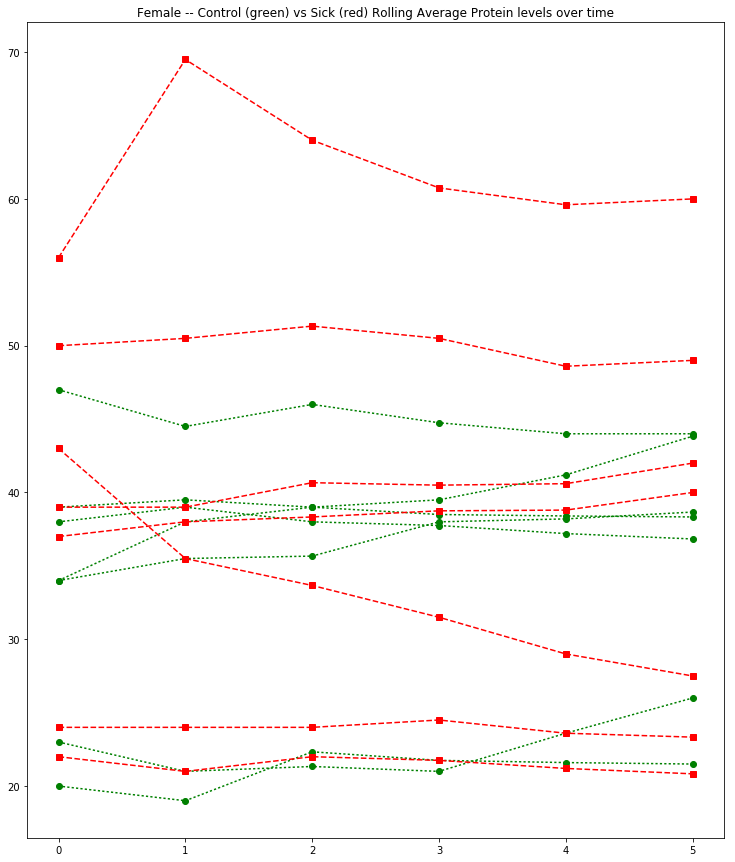

In [71]:
rollingAverageControlFemales = computeRollingAverages(controlFemales)
rollingAverageSickFemales = computeRollingAverages(sickFemales)

randomAvgControlFemales = selectRandom(rollingAverageControlFemales, 7)
randomAvgSickFemales = selectRandom(rollingAverageSickFemales, 7)

labels = []
for entry in randomAvgControlFemales:
    labels.append(0)
for entry in randomAvgSickFemales:
    labels.append(1)

allFullyFilledAvgFemales = randomAvgControlFemales + randomAvgSickFemales
colors = ['go:', 'rs--']
title = "Female -- Control (green) vs Sick (red) Rolling Average Protein levels over time"

usefulFunctions.createLinePlotsOnSamePlot(allFullyFilledAvgFemales, labels, colors, title)
# green is control
# red is sick

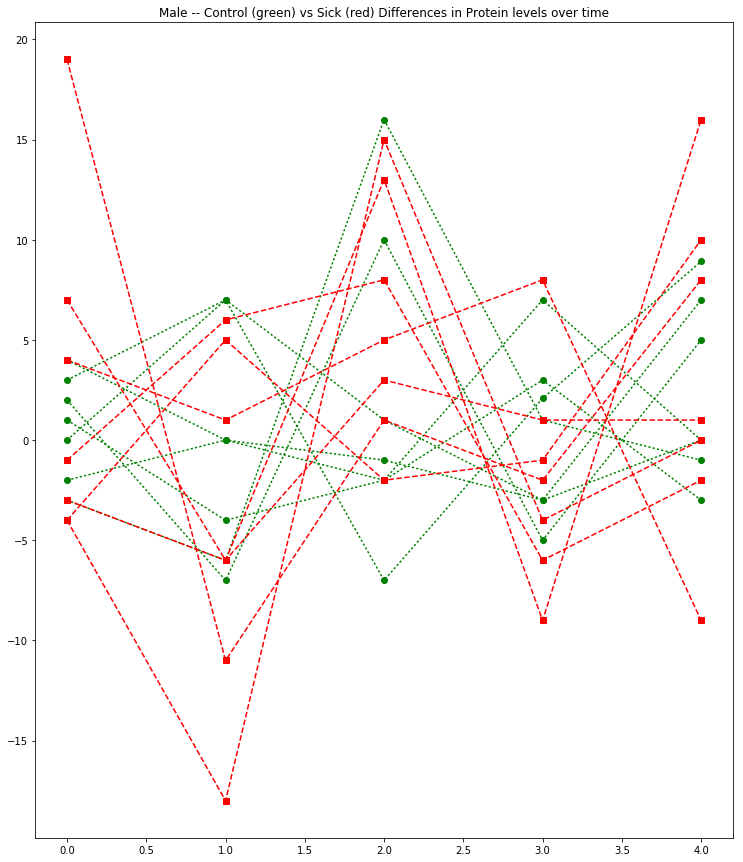

In [68]:
def computeDifferences(matrix, absolute = True):
    differenceMatrix = []
    for i in range(len(matrix)):
        row = matrix[i]
        temp = []
        for j in range(1,len(row)):
            if absolute:
                temp.append(abs(row[j-1]-row[j]))
            else:
                temp.append((row[j]-row[j-1]))
        
        differenceMatrix.append([])
        for j in range(len(temp)):
            differenceMatrix[i].append(temp[j])
    return differenceMatrix

randomDiffControlMales = selectRandom(computeDifferences(controlMales, False), 7)
randomDiffSickMales = selectRandom(computeDifferences(sickMales, False), 7)

labels = []
for entry in randomDiffControlMales:
    labels.append(0)
for entry in randomDiffSickMales:
    labels.append(1)

allFullyFilledDiffMales = randomDiffControlMales + randomDiffSickMales
colors = ['go:', 'rs--']
title = "Male -- Control (green) vs Sick (red) Differences in Protein levels over time"

usefulFunctions.createLinePlotsOnSamePlot(allFullyFilledDiffMales, labels, colors, title)
# green is control
# red is sick       

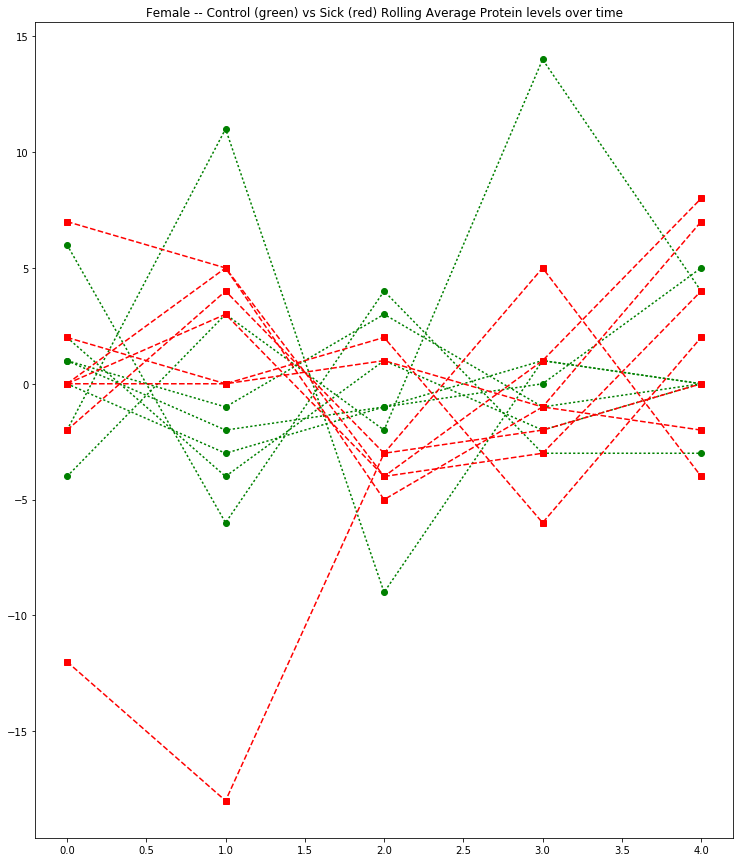

In [69]:
randomDiffControlFemales = selectRandom(computeDifferences(controlFemales, False), 7)
randomDiffSickFemales = selectRandom(computeDifferences(sickFemales, False), 7)

labels = []
for entry in randomDiffControlFemales:
    labels.append(0)
for entry in randomDiffSickFemales:
    labels.append(1)

allFullyFilledDiffFemales = randomDiffControlFemales + randomDiffSickFemales
colors = ['go:', 'rs--']
title = "Female -- Control (green) vs Sick (red) Rolling Average Protein levels over time"

usefulFunctions.createLinePlotsOnSamePlot(allFullyFilledDiffFemales, labels, colors, title)